<br/>

$$ \huge{\underline{\textbf{ Playing Atari Games with Deep RL }}} $$

$$ \large{\textbf{MountainCar + DQN + Memory Reply}} $$

<br/>



# Introduction

This notebooks presents basic **Deep Q-Network (DQN)** used to solve OpenAI Gym **Classic Control** environments like Mountain Car, Inverted Pendulum and so on. In this notebook we use DQN **without target network** for educational purposes. For practical applications use target network.

# Imports

Imports

In [1]:
import os
import datetime
import itertools
import collections
import numpy as np
import matplotlib.pyplot as plt

Import OpenAI Gym

In [2]:
import gym

Initialise TensorFlow

In [3]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)  # init TF ...
config=tf.ConfigProto(gpu_options=gpu_options)  # w/o taking ...
with tf.Session(config=config): pass            # all GPU memory

Import helpers for plotting (source file: [helpers.py](helpers.py))

In [4]:
import helpers
import importlib
importlib.reload(helpers);

# Q-Learning

Epsilon random policy

In [5]:
def policy(st, model, eps):
    if np.random.rand() > eps:
        q_values = model.eval(np.stack([st]))
        return np.argmax(q_values)
    else:
        return env.action_space.sample()

Main training loop. Supports resuming from pre-trained agent and callbacks.

In [6]:
def q_learning(env, frames, gamma, eps_decay_steps, eps_target,
               batch_size, model, mem, start_step=0,
               callback=None, trace=None, render=False):
    """Q-Learning, supprots resume
    
    Note: If resuming, all parameters should be identical to original call, with
        exception of 'start_step' and 'frames'.
    
    Params:
        env - environment
        frames - number of time steps to execute
        gamma - discount factor [0..1]
        eps_decay_steps - decay epsilon-greedy param over that many time steps
        eps_target - epsilon-greedy param after decay
        batch_size - neural network batch size from memory buffer
        model      - function approximator, already initialised, with methods:
                     eval(state, action) -> float
                     train(state, target) -> None
        mem - memory reply buffer
        start_step - if continuning, pass in return value (tts_) here
        callback - optional callback to execute
        trace - this object handles data logging, plotting etc.
        render - render openai gym environment?
    """
    
    def eps_schedule(tts, eps_decay_steps, eps_target):
        if tts > eps_decay_steps:
            return eps_target
        else:
            eps_per_step_change = (1-eps_target) / eps_decay_steps
            return 1.0 - tts * eps_per_step_change
    
        
    assert len(mem) >= batch_size
    
    tts_ = start_step                        # total time step
    for _ in itertools.count():              # count from 0 to infinity
        
        S = env.reset()
        episode_reward = 0                   # purely for logging
        if render: env.render()
        
        for t_ in itertools.count():         # count from 0 to infinity
            
            eps = eps_schedule(tts_, eps_decay_steps, eps_target)
            
            A = policy(S, model, eps)
            
            S_, R, done, _ = env.step(A)
            episode_reward += R
            if render: env.render()
            
            mem.append(S, A, R, S_, done)
            
            if callback is not None:
                callback(tts_, t_, S, A, R, done, eps, episode_reward, model, mem, trace)
            
            states, actions, rewards, n_states, dones, _ = mem.get_batch(batch_size)
            targets = model.eval(n_states)
            targets = rewards + gamma * np.max(targets, axis=-1)
            targets[dones] = rewards[dones]  # return of next-to-terminal state is just R
            model.train(states, actions, targets)

            S = S_
            
            tts_ += 1
            if tts_ >= start_step + frames:
                return tts_                  # so we can pick up where we left
            
            if done:
                break

Stripped down version for evaluation. Does not train agent.

In [7]:
def evaluate(env, model, frames=None, episodes=None, eps=0.0, render=False):
    assert frames is not None or episodes is not None
        
    total_reward = 0
    
    tts_ = 0                                 # total time step
    for e_ in itertools.count():             # count from 0 to infinity
        if episodes is not None and e_ >= episodes:
            return total_reward
        
        S = env.reset()
        if render: env.render()
        
        for t_ in itertools.count():         # count from 0 to infinity
            
            A = policy(S, model, eps)
            
            S_, R, done, _ = env.step(A)
            total_reward += R
            if render: env.render()
    
            S = S_
            
            tts_ += 1
            if frames is not None and tts_ >= frames:
                return
            
            if done:
                break

Stripped down version to pre-fill memory buffer with random policy.

In [8]:
def mem_fill(env, mem, steps=None, episodes=None, render=False):
        
    # Fill memory buffer using random policy
    tts_ = 0
    for e_ in itertools.count():
        if episodes is not None and e_ >= episodes:
            return
        
        S = env.reset();
        if render: env.render()
        
        for t_ in itertools.count():
        
            A = env.action_space.sample()    # random policy
            S_, R, done, _ = env.step(A)
            if render: env.render()
                
            mem.append(S, A, R, S_, done)
            
            S = S_
            
            tts_ += 1
            if steps is not None and tts_ >= steps:
                return
            
            if done:
                break

# Function Approximators and Memory

Definition of simple neural network with two hidden layers. As as side note, for classic control tasks tilings work much better.

In [75]:
class TFNeuralNet():
    def __init__(self, nb_in, nb_hid_1, nb_hid_2, nb_out, lr):
        self.nb_in = nb_in
        self.nb_hid_1 = nb_hid_1
        self.nb_hid_2 = nb_hid_2
        self.nb_out = nb_out
        
        tf.reset_default_graph()
              
        self._x = tf.placeholder(name='xx', shape=[None, nb_in], dtype=tf.float32)
        self._y = tf.placeholder(name='yy', shape=[None, nb_out], dtype=tf.float32)

        self._h_hid_1 = tf.layers.dense(self._x, units=nb_hid_1,
                                        activation=tf.nn.relu, name='Hidden_1')
        self._h_hid_2 = tf.layers.dense(self._h_hid_1, units=nb_hid_2,
                                        activation=tf.nn.relu, name='Hidden_2')
        self._y_hat = tf.layers.dense(self._h_hid_2, units=nb_out,
                                      activation=None, name='Output')
        self._loss = tf.losses.mean_squared_error(self._y, self._y_hat)

        self._optimizer = tf.train.RMSPropOptimizer(learning_rate=lr)
        self._train_op = self._optimizer.minimize(self._loss)

        self._sess = tf.Session()
        self._sess.run(tf.global_variables_initializer())
        
    def backward(self, x, y):
        assert x.ndim == y.ndim == 2
        _, y_hat, loss = self._sess.run([self._train_op, self._y_hat, self._loss],
                                         feed_dict={self._x: x, self._y:y})
        return y_hat, loss
    
    def forward(self, x):
        return self._sess.run(self._y_hat, feed_dict={self._x: x})
    
    def save(self, filepath):
        saver = tf.train.Saver()
        saver.save(self._sess, filepath)
        
    def load(self, filepath):
        saver = tf.train.Saver()
        saver.restore(self._sess, filepath)

Function approximator wrapper. Mostly performs sanity check and input/output normalisation.

In [10]:
class TFFunctApprox():

    def __init__(self, model, st_low, st_high, rew_mean, rew_std, nb_actions):
        """Q-function approximator using Keras model

        Args:
            model: TFNeuralNet model
        """
        st_low = np.array(st_low);
        st_high = np.array(st_high)
        self._model = model
        
        assert st_low.ndim == 1 and st_low.shape == st_high.shape
        
        if len(st_low) != model.nb_in:
            raise ValueError('Input shape does not match state_space shape')

        if nb_actions != model.nb_out:
            raise ValueError('Output shape does not match action_space shape')

        # normalise inputs
        self._offsets = st_low + (st_high - st_low) / 2
        self._scales = 1 / ((st_high - st_low) / 2)
        
        self._rew_mean = rew_mean
        self._rew_std = rew_std

    def eval(self, states):
        assert isinstance(states, np.ndarray)
        assert states.ndim == 2

        inputs = (states - self._offsets) * self._scales

        y_hat = self._model.forward(inputs)
        
        #return y_hat
        return y_hat*self._rew_std + self._rew_mean

    def train(self, states, actions, targets):
        
        assert isinstance(states, np.ndarray)
        assert isinstance(actions, np.ndarray)
        assert isinstance(targets, np.ndarray)
        assert states.ndim == 2
        assert actions.ndim == 1
        assert targets.ndim == 1
        assert len(states) == len(actions) == len(targets)
        
        
        targets = (targets-self._rew_mean) / self._rew_std    # normalise

        inputs = (states - self._offsets) * self._scales
        all_targets = self._model.forward(inputs)       # this should normalised already
        all_targets[np.arange(len(all_targets)), actions] = targets
        self._model.backward(inputs, all_targets)


Memory reply buffer. Reasonably fast impl., doesn't do memory copies when picking batches. This will be useful for Atari. Python deque is very slow.

In [11]:
class Memory:
    """Circular buffer for DQN memory reply. Fairly fast."""

    def __init__(self, max_len, state_shape, state_dtype):
        """
        Args:
            max_len: maximum capacity
        """
        assert isinstance(max_len, int)
        assert max_len > 0

        self.max_len = max_len                      # maximum length        
        self._curr_insert_ptr = 0                   # index to insert next data sample
        self._curr_len = 0                          # number of currently stored elements

        state_arr_shape = [max_len] + list(state_shape)

        self._hist_St = np.zeros(state_arr_shape, dtype=state_dtype)
        self._hist_At = np.zeros(max_len, dtype=int)
        self._hist_Rt_1 = np.zeros(max_len, dtype=float)
        self._hist_St_1 = np.zeros(state_arr_shape, dtype=state_dtype)
        self._hist_done_1 = np.zeros(max_len, dtype=bool)

    def append(self, St, At, Rt_1, St_1, done_1):
        """Add one sample to memory, override oldest if max_len reached.

        Args:
            St [np.ndarray]   - state
            At [int]          - action
            Rt_1 [float]      - reward
            St_1 [np.ndarray] - next state
            done_1 [bool]       - next state terminal?
        """
        self._hist_St[self._curr_insert_ptr] = St
        self._hist_At[self._curr_insert_ptr] = At
        self._hist_Rt_1[self._curr_insert_ptr] = Rt_1
        self._hist_St_1[self._curr_insert_ptr] = St_1
        self._hist_done_1[self._curr_insert_ptr] = done_1
        
        if self._curr_len < self.max_len:                 # keep track of current length
            self._curr_len += 1
            
        self._curr_insert_ptr += 1                        # increment insertion pointer
        if self._curr_insert_ptr >= self.max_len:         # roll to zero if needed
            self._curr_insert_ptr = 0

    def __len__(self):
        """Number of samples in memory, 0 <= length <= max_len"""
        return self._curr_len

    def get_batch(self, batch_len):
        """Sample batch of data, with repetition

        Args:
            batch_len: nb of samples to pick

        Returns:
            states, actions, rewards, next_states, next_done, indices
            Each returned element is np.ndarray with length == batch_len
        """
        assert self._curr_len > 0
        assert batch_len > 0

        
        indices = np.random.randint(        # randint much faster than np.random.sample
            low=0, high=self._curr_len, size=batch_len, dtype=int)

        states = np.take(self._hist_St, indices, axis=0)
        actions = np.take(self._hist_At, indices, axis=0)
        rewards_1 = np.take(self._hist_Rt_1, indices, axis=0)
        states_1 = np.take(self._hist_St_1, indices, axis=0)
        dones_1 = np.take(self._hist_done_1, indices, axis=0)

        return states, actions, rewards_1, states_1, dones_1, indices


    
    def pick_last(self, nb):
        """Pick last nb elements from memory
        
        Returns:
            states, actions, rewards, next_states, done_1, indices
            Each returned element is np.ndarray with length == batch_len
        """
        assert nb <= self._curr_len
        
        start = self._curr_insert_ptr - nb                # inclusive
        end = self._curr_insert_ptr                       # not inclusive
        indices = np.array(range(start,end), dtype=int)   # indices to pick, can be neg.
        indices[indices < 0] += self._curr_len            # loop negative to positive
        
        states = np.take(self._hist_St, indices, axis=0)
        actions = np.take(self._hist_At, indices, axis=0)
        rewards_1 = np.take(self._hist_Rt_1, indices, axis=0)
        states_1 = np.take(self._hist_St_1, indices, axis=0)
        dones_1 = np.take(self._hist_done_1, indices, axis=0)
        
        return states, actions, rewards_1, states_1, dones_1, indices
    

---

# Experiment Setup

Environment wrapper to skip frames. Also known as _action repeat_. Really helps with some environments, e.g. mountain car.

In [12]:
class WrapFrameSkip():
    def __init__(self, env, frameskip):
        assert frameskip >= 1
        self._env = env
        self._frameskip = frameskip
        self.observation_space = env.observation_space
        self.action_space = env.action_space
    
    def reset(self):
        return self._env.reset()
    
    def step(self, action):
        sum_rew = 0
        for _ in range(self._frameskip):
            obs, rew, done, info = self._env.step(action)
            sum_rew += rew
            if done: break
        return obs, sum_rew, done, info
    
    def render(self, mode='human'):
        return self._env.render(mode=mode)
        
    def close(self):
        self._env.close()               

This object is a basic data logger. If you don't want to generate plots, you can mostly ignore it

In [13]:
class Trace():
    def __init__(self, eval_every, render=False, test_states=None, state_labels=None):
        
        if test_states is not None:
            assert test_states.ndim == 2
            
        self.enable_plotting = False
        
        self.eval_every = eval_every
        self.test_states = test_states
        self.state_labels = state_labels
        
        self.tstep = 0
        self.total_tstep = 0
        
        self.q_values = collections.OrderedDict()
        self.ep_rewards = collections.defaultdict(float)
        self.last_ep_reward = None
        
        self.states = []
        self.actions = []
        self.rewards = []  # t+1
        self.dones = []    # t+1
        self.epsilons = []

Callback which is called every single training iteration, it does as follows:
* fill up trace object with basic logging data
* print training progress
* perform evaluation of `test_states`
* optionally plot agent state

In [14]:
def callback(total_time_step, tstep, st, act, rew_, done_,
             eps, ep_reward, model, memory, trace):
    """Called from gradient_MC after every episode.
    
    Params:
        episode [int] - episode number
        tstep [int]   - timestep within episode
        model [obj]   - function approximator
        trace [list]  - list to write results to"""
    
    assert total_time_step == trace.total_tstep
    
    trace.tstep = tstep
    
    trace.states.append(st)
    trace.actions.append(act)
    trace.rewards.append(rew_)
    trace.dones.append(done_)
    trace.epsilons.append(eps)
        
    if done_:
        trace.ep_rewards[total_time_step] = ep_reward
        trace.last_ep_reward = ep_reward
            
    #
    #   Print, Evaluate, Plot
    #
    if (trace.eval_every is not None) and (trace.total_tstep % trace.eval_every == 0):
        
        print(f'wall: {datetime.datetime.now().strftime("%H:%M:%S")}   '
              f'ep: {len(trace.ep_rewards):3}   tstep: {tstep:4}   '
              f'total tstep: {trace.total_tstep:6}   '
              f'eps: {eps:5.3f}   reward: {trace.last_ep_reward:.3f}   ')

        if len(st) == 2:
            # We are working with 2D environment,
            # eval. Q-Value function across whole state space
            q_arr = helpers.eval_state_action_space(model, env, split=[128,128])
            trace.q_values[trace.total_tstep] = q_arr
        else:
            # Environment is not 2D,
            # eval. on pre-defined random sample of states
            if trace.test_states is not None:
                y_hat = model.eval(trace.test_states)
                trace.q_values[trace.total_tstep] = y_hat

        if trace.enable_plotting:
            helpers.plot_all(env, model, memory, trace)
            print('■'*80)

    trace.total_tstep += 1

---

# MountainCar

Start with mountain car environment

Notes:
* OpenAI gym imposes **200 step limit**, which makes this environment *extremely* hard to solve with DQN - we remove this limit
* Frame-skip (aka action repeat) is technically not necessary, but makes training *much* easier, good value is frameskip=4

The nut and bolt of mountain car is that agent gets extremely sparse reward on successful exit. Shortest possible exit trajectory is approx 120-130 steps. If we impose 200 step limit and don't repeat actions this means agent has to perform series of 120-130 actions exactly correctly in the row with very little margin for error. If agent doesn't succeed it gets reset back to beginning on step 200. To do this with random exploratory policy is virtually impossible.

Note that this can still be solved easily with linear function approximation (local updates) and optimistic initialisation which facilitates continuing exploration. This is not possible with DQN.

In [15]:
def experiment_mountaincar():
    neural_net = TFNeuralNet(nb_in=2, nb_hid_1=64, nb_hid_2=64, nb_out=3, lr=0.00025)
    
    model = TFFunctApprox(neural_net,
                          env.observation_space.low,
                          env.observation_space.high,
                          rew_mean=-50,
                          rew_std=15,
                          nb_actions=env.action_space.n)
    
    mem = Memory(max_len=100000, state_shape=(2,), state_dtype=float)
    mem_fill(env, mem, steps=10000)
    test_states, _, _, _, _, _ = mem.get_batch(10)
    
    trace = Trace(eval_every=1000, test_states=test_states)
    
    return trace, model, mem

Setup the experiment

In [16]:
env = gym.make('MountainCar-v0').env  # remove 200 step limit
env = WrapFrameSkip(env, frameskip=2)
trace, model, mem = experiment_mountaincar()
# trace.enable_plotting = True

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Train the agent

In [17]:
tts = q_learning(env, frames=15000, gamma=.99,
                 eps_decay_steps=20000, eps_target=0.1, batch_size=4096,
                 model=model, mem=mem, callback=callback, trace=trace)

wall: 07:53:16   ep:   0   tstep:    0   total tstep:      0   eps: 1.000   reward: None   
wall: 07:53:22   ep:   0   tstep: 1000   total tstep:   1000   eps: 0.955   reward: None   
wall: 07:53:27   ep:   0   tstep: 2000   total tstep:   2000   eps: 0.910   reward: None   
wall: 07:53:32   ep:   1   tstep:  316   total tstep:   3000   eps: 0.865   reward: -5367.0   
wall: 07:53:37   ep:   3   tstep:  413   total tstep:   4000   eps: 0.820   reward: -968.0   
wall: 07:53:42   ep:   5   tstep:  271   total tstep:   5000   eps: 0.775   reward: -798.0   
wall: 07:53:47   ep:  10   tstep:   11   total tstep:   6000   eps: 0.730   reward: -427.0   
wall: 07:53:53   ep:  13   tstep:   63   total tstep:   7000   eps: 0.685   reward: -863.0   
wall: 07:53:58   ep:  18   tstep:  169   total tstep:   8000   eps: 0.640   reward: -252.0   
wall: 07:54:04   ep:  24   tstep:   59   total tstep:   9000   eps: 0.595   reward: -334.0   
wall: 07:54:09   ep:  32   tstep:   19   total tstep:  10000   ep

Optional: train some more

In [18]:
# tts = q_learning(env, frames=5000, gamma=.99,
#                  eps_decay_steps=20000, eps_target=0.1, batch_size=4096,
#                  model=model, mem=mem, start_step=tts, callback=callback, trace=trace)

Optional: plot the agent state

wall: 07:54:41   ep:  84   tstep:   44   total tstep:  15000   eps: 0.325   reward: -145.0   


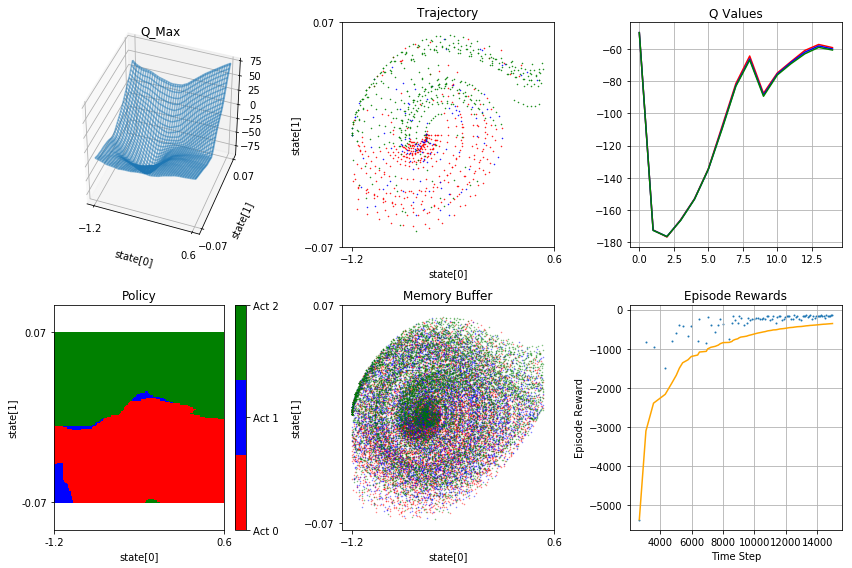

In [19]:
helpers.plot_all(env, model, mem, trace, print_=True)

Save weights

In [20]:
model._model.save('./tf_models/MountainCar.ckpt')

Load weights

In [21]:
model._model.load('./tf_models/MountainCar.ckpt')

INFO:tensorflow:Restoring parameters from ./tf_models/MountainCar.ckpt


Enjoy trained agent

In [22]:
try: evaluate(env, model, frames=float('inf'), eps=0.0, render=True)
except KeyboardInterrupt: pass
finally: env.close()

**Result**

Expected agent behaviour after 15000 iterations

<img src="assets/mountaincar.gif"/>

If you enable plotting, then output after training should be in roughly as follows

```
wall: 16:45:30   ep:  91   tstep:   22   total tstep:  15000   eps: 0.325   reward: -134.0
```

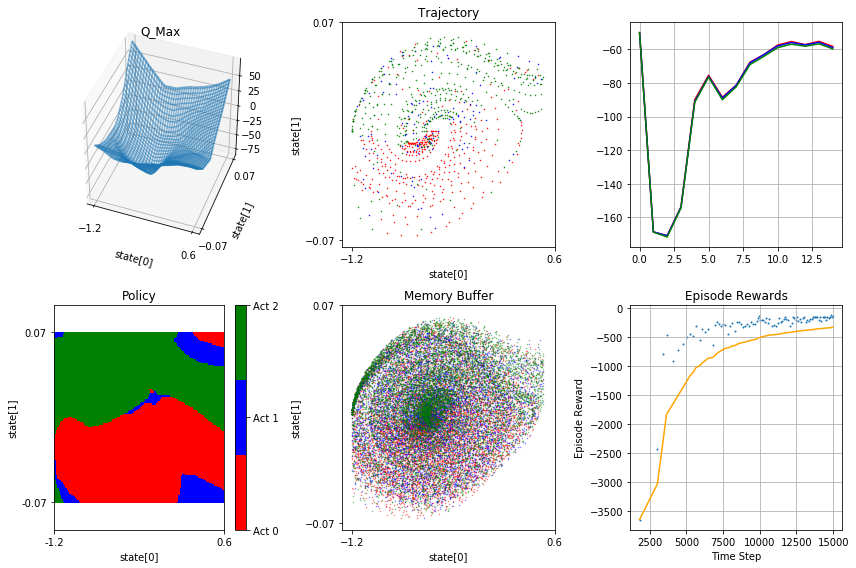

Where:
* Q_Max - is a plot of q-function max over possible actions
* Trajectory - is top-down view of agent trajectory. Agent starts roughly in the centre and exits to the right. Colour indicates action, see policy plot
* Q Values - is a plot of average q-values for set or randomly selected states - this shows how q-values develop during training
* Policy - is a top-down plot of agent policy. Green is accelerate right, red is accelerate left, blue is neutral
* Memory Buffer - is a snapshot of memory buffer, same format as Trajectory plot
* Episode Rewards - individual rewards acquired (blue dots) and running average (yellow) over the training period

# Pendulum

Pendulum is in my opinion actually quite a bit easier than mountain car. Mainly because of rich reward signal.

Notes:
* OpenAI pendulum has continuous actions while basic DQN requires discrete actions - we will discretise it
* by default state space is 3-vector: [cos(angle), sin(angle), velocity] - to be able to plot whole state space we reduce it to [angle, velocity]

In [52]:
class Pendulum2DEnv():
    def __init__(self):
        self._env = gym.make('Pendulum-v0')
        
        self.observation_space = gym.spaces.Box(
            low=np.array([-np.pi, -8.0]), high=np.array([np.pi, 8.0]), dtype=np.float32 )
        self.action_space = gym.spaces.Discrete(n=3)
        
    def reset(self):
        cos, sin, vel = self._env.reset()
        theta = np.arctan2(sin, cos)
        return np.array([theta, vel])
        
    def step(self, action):
        torques = [-2.0, 0.0, 2.0]
        # torques = [-2.0, -.5, 0.0, .5, 2.0]
        joint_effort = torques[action]
        
        obs, rew, done, _ = self._env.step([joint_effort])
        cos, sin, vel = obs
        theta = np.arctan2(sin, cos)
        return np.array([theta, vel]), rew, done, obs
    
    def render(self, mode='human'):
        return self._env.render(mode=mode)
        
    def close(self):
        self._env.close()

In [53]:
def experiment_pendulum():
    neural_net = TFNeuralNet(nb_in=2, nb_hid_1=64, nb_hid_2=64, nb_out=3, lr=0.00025)
    
    model = TFFunctApprox(neural_net,
                          env.observation_space.low,
                          env.observation_space.high,
                          rew_mean=-210,
                          rew_std=50,
                          nb_actions=env.action_space.n)
    
    mem = Memory(max_len=100000, state_shape=(2,), state_dtype=float)
    mem_fill(env, mem, steps=10000)
    test_states, _, _, _, _, _ = mem.get_batch(10)
    
    trace = Trace(eval_every=1000, test_states=test_states)
    
    return trace, model, mem

Setup the experiment

In [55]:
env = Pendulum2DEnv()
env = WrapFrameSkip(env, frameskip=2)
trace, model, mem = experiment_pendulum()
# trace.enable_plotting = True

Train the agent

In [57]:
tts = q_learning(env, frames=25000, gamma=.99,
                 eps_decay_steps=20000, eps_target=0.1, batch_size=4096,
                 model=model, mem=mem, callback=callback, trace=trace)

wall: 08:11:07   ep:   0   tstep:    0   total tstep:      0   eps: 1.000   reward: None   
wall: 08:11:12   ep:  10   tstep:    0   total tstep:   1000   eps: 0.955   reward: -1516.720893778504   
wall: 08:11:17   ep:  20   tstep:    0   total tstep:   2000   eps: 0.910   reward: -939.8787544378946   
wall: 08:11:22   ep:  30   tstep:    0   total tstep:   3000   eps: 0.865   reward: -1182.6656568913631   
wall: 08:11:27   ep:  40   tstep:    0   total tstep:   4000   eps: 0.820   reward: -979.5373686674061   
wall: 08:11:32   ep:  50   tstep:    0   total tstep:   5000   eps: 0.775   reward: -855.1887101688923   
wall: 08:11:38   ep:  60   tstep:    0   total tstep:   6000   eps: 0.730   reward: -877.9556792532994   
wall: 08:11:43   ep:  70   tstep:    0   total tstep:   7000   eps: 0.685   reward: -983.3250468681615   
wall: 08:11:49   ep:  80   tstep:    0   total tstep:   8000   eps: 0.640   reward: -759.3098103822938   
wall: 08:11:54   ep:  90   tstep:    0   total tstep:   900

Optional: train some more

In [59]:
# tts = q_learning(env, frames=5000, gamma=.99,
#                  eps_decay_steps=20000, eps_target=0.1, batch_size=4096,
#                  model=model, mem=mem, start_step=tts, callback=callback, trace=trace)

Optional: plot the agent state

wall: 08:13:49   ep: 250   tstep:   99   total tstep:  25000   eps: 0.100   reward: -227.5303573723496   


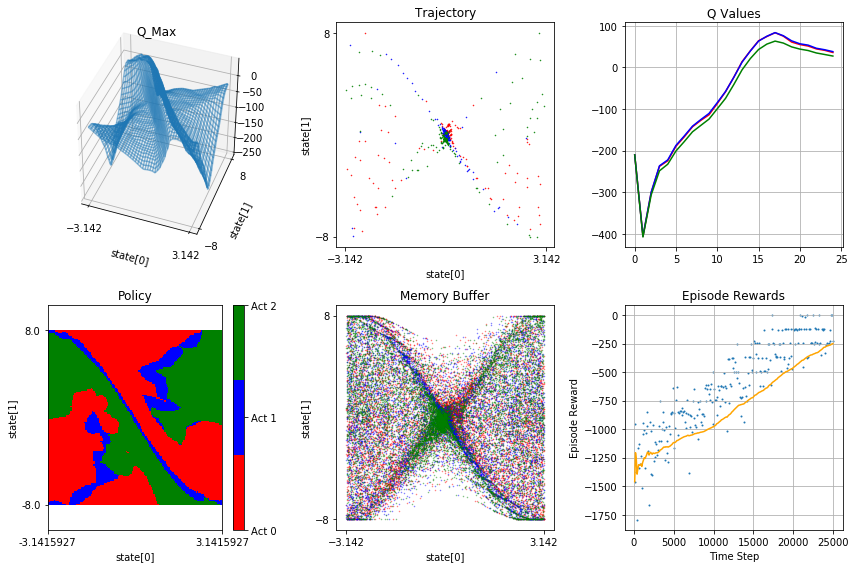

In [60]:
helpers.plot_all(env, model, mem, trace, print_=True)

Save weights

In [61]:
model._model.save('./tf_models/Pendulum.ckpt')

Load weights

In [62]:
model._model.load('./tf_models/Pendulum.ckpt')

INFO:tensorflow:Restoring parameters from ./tf_models/Pendulum.ckpt


Enjoy trained agent

In [63]:
try: evaluate(env, model, frames=float('inf'), eps=0.0, render=True)
except KeyboardInterrupt: pass
finally: env.close()

**Result**

Expected agent behaviour after 25000 iterations

<img src="assets/pendulum.gif"/>

If you enable plotting, then output after training should be in roughly as follows

```
wall: 08:13:49   ep: 250   tstep:   99   total tstep:  25000   eps: 0.100   reward: -227.530
```

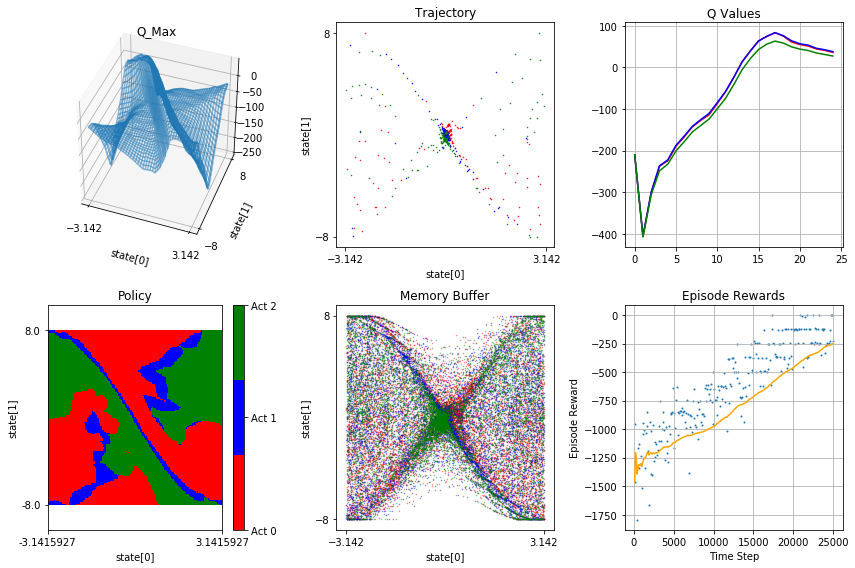

Where:
* Q_Max - is a plot of q-function max over possible actions
* Trajectory - is top-down view of agent trajectory. Agent starts roughly in the centre and exits to the right. Colour indicates action, see policy plot
* Q Values - is a plot of average q-values for set or randomly selected states - this shows how q-values develop during training
* Policy - is a top-down plot of agent policy. Green is accelerate right, red is accelerate left, blue is neutral
* Memory Buffer - is a snapshot of memory buffer, same format as Trajectory plot
* Episode Rewards - individual rewards acquired (blue dots) and running average (yellow) over the training period

# Cartpole

Everybody loves cartpole!

Notes:
* this environment no longer has 2d state space so we can't plot it all :( - as a result plots look differently

This environment has peculiar dynamic where positive reward, along with non-corrected maximisation bias in Q-Function (we don't use Dual-DQN) causes runaway Q-Value effect where Q-Values increase continuously. This is ok for now, because RELATIVE Q-Values are still good enough to select correct action. I think using target network along with Dual-DQN would help with this problem.

In [78]:
def experiment_cartpole():
    neural_net = TFNeuralNet(nb_in=4, nb_hid_1=64, nb_hid_2=64, nb_out=2, lr=0.00025)
    
    model = TFFunctApprox(neural_net,
                          st_low=np.array([-.2, -1.0, -0.15, -1.0]),
                          st_high=np.array([.2, 1.0, 0.15, 1.0]),
                          rew_mean=0,
                          rew_std=1,
                          nb_actions=env.action_space.n)
    
    mem = Memory(max_len=100000, state_shape=(4,), state_dtype=float)
    mem_fill(env, mem, steps=10000)
    test_states, _, _, _, _, _ = mem.get_batch(10)
    
    trace = Trace(eval_every=1000, test_states=test_states)
    
    return trace, model, mem

Setup the experiment

In [81]:
env = env = gym.make('CartPole-v0')
#env = WrapFrameSkip(env, frameskip=2)
trace, model, mem = experiment_cartpole()
# trace.enable_plotting = True

Train the agent

In [82]:
tts = q_learning(env, frames=25000, gamma=.99,
                 eps_decay_steps=20000, eps_target=0.1, batch_size=4096,
                 model=model, mem=mem, callback=callback, trace=trace)

wall: 09:08:58   ep:   0   tstep:    0   total tstep:      0   eps: 1.000   reward: None   
wall: 09:09:03   ep:  48   tstep:   10   total tstep:   1000   eps: 0.955   reward: 10.0   
wall: 09:09:08   ep:  88   tstep:   34   total tstep:   2000   eps: 0.910   reward: 23.0   
wall: 09:09:13   ep: 137   tstep:    9   total tstep:   3000   eps: 0.865   reward: 17.0   
wall: 09:09:18   ep: 167   tstep:   36   total tstep:   4000   eps: 0.820   reward: 21.0   
wall: 09:09:23   ep: 190   tstep:    6   total tstep:   5000   eps: 0.775   reward: 51.0   
wall: 09:09:29   ep: 212   tstep:  197   total tstep:   6000   eps: 0.730   reward: 22.0   
wall: 09:09:34   ep: 230   tstep:   44   total tstep:   7000   eps: 0.685   reward: 25.0   
wall: 09:09:40   ep: 242   tstep:   51   total tstep:   8000   eps: 0.640   reward: 54.0   
wall: 09:09:45   ep: 251   tstep:  119   total tstep:   9000   eps: 0.595   reward: 79.0   
wall: 09:09:51   ep: 260   tstep:   28   total tstep:  10000   eps: 0.550   rewa

Optional: train some more

In [83]:
# tts = q_learning(env, frames=5000, gamma=.99,
#                  eps_decay_steps=20000, eps_target=0.1, batch_size=4096,
#                  model=model, mem=mem, start_step=tts, callback=callback, trace=trace)

Optional: plot the agent state

In [103]:
# helpers.plot_all(env, model, mem, trace, print_=True)

Save weights

In [85]:
model._model.save('./tf_models/CartPole.ckpt')

Load weights

In [86]:
model._model.load('./tf_models/CartPole.ckpt')

INFO:tensorflow:Restoring parameters from ./tf_models/CartPole.ckpt


Enjoy trained agent

In [87]:
try: evaluate(env, model, frames=float('inf'), eps=0.0, render=True)
except KeyboardInterrupt: pass
finally: env.close()

**Result**

Expected agent behaviour after 25000 iterations

<img src="assets/cartpole.gif"/>

If you enable plotting, then output after training should be in roughly as follows

```
wall: 09:11:13   ep: 335   tstep:   73   total tstep:  24000   eps: 0.100   reward: 200.0
```

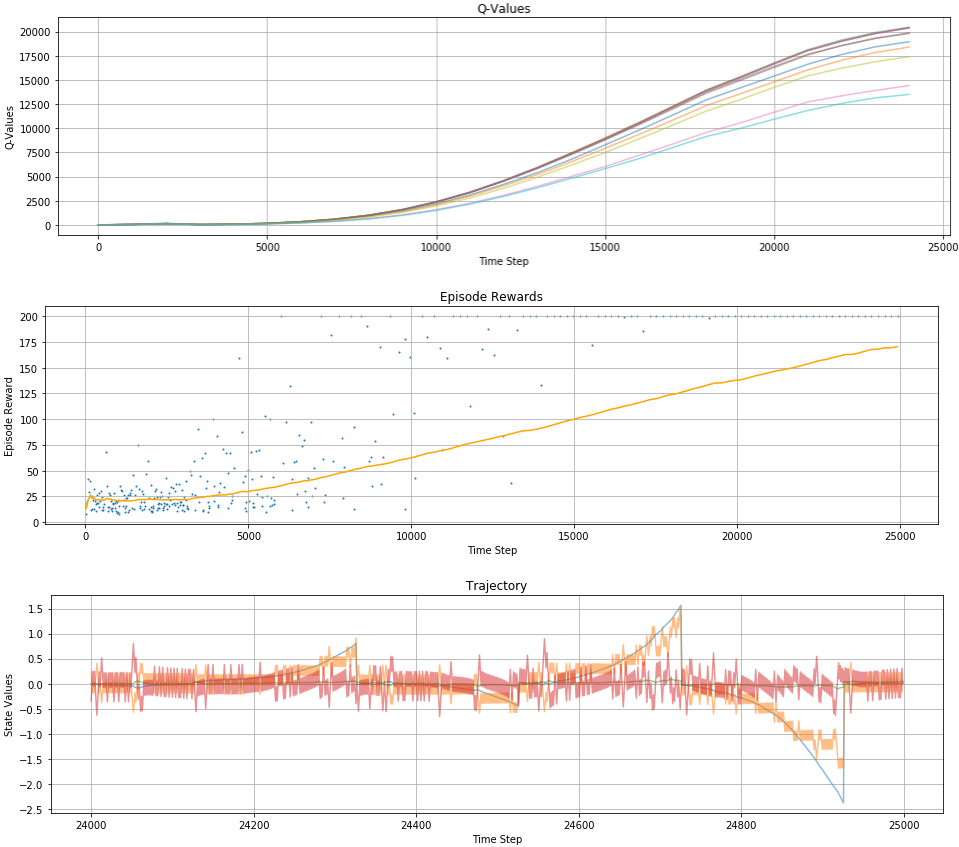

Where:
* Q_Max - is a plot of q-function max over possible actions
* Trajectory - is top-down view of agent trajectory. Agent starts roughly in the centre and exits to the right. Colour indicates action, see policy plot
* Q Values - is a plot of average q-values for set or randomly selected states - this shows how q-values develop during training
* Policy - is a top-down plot of agent policy. Green is accelerate right, red is accelerate left, blue is neutral
* Memory Buffer - is a snapshot of memory buffer, same format as Trajectory plot
* Episode Rewards - individual rewards acquired (blue dots) and running average (yellow) over the training period

# Acrobot

This is a variation of pendulum environment

In [108]:
def experiment_acrobot():
    neural_net = TFNeuralNet(nb_in=6, nb_hid_1=64, nb_hid_2=64, nb_out=3, lr=0.00025)
    
    model = TFFunctApprox(neural_net,
                          env.observation_space.low,
                          env.observation_space.high,
                          rew_mean=-70,
                          rew_std=10,
                          nb_actions=env.action_space.n)
    
    mem = Memory(max_len=100000, state_shape=(6,), state_dtype=float)
    mem_fill(env, mem, steps=10000)
    test_states, _, _, _, _, _ = mem.get_batch(10)
    
    trace = Trace(eval_every=1000, test_states=test_states)
    
    return trace, model, mem

Setup the experiment

In [111]:
env = env = gym.make('Acrobot-v1')
env = WrapFrameSkip(env, frameskip=2)
trace, model, mem = experiment_acrobot()
# trace.enable_plotting = True

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Train the agent

In [112]:
tts = q_learning(env, frames=25000, gamma=.99,
                 eps_decay_steps=20000, eps_target=0.1, batch_size=4096,
                 model=model, mem=mem, callback=callback, trace=trace)

wall: 09:20:42   ep:   0   tstep:    0   total tstep:      0   eps: 1.000   reward: None   
wall: 09:20:48   ep:   4   tstep:    7   total tstep:   1000   eps: 0.955   reward: -500.0   
wall: 09:20:54   ep:   9   tstep:   31   total tstep:   2000   eps: 0.910   reward: -449.0   
wall: 09:21:00   ep:  15   tstep:   45   total tstep:   3000   eps: 0.865   reward: -246.0   
wall: 09:21:06   ep:  20   tstep:  108   total tstep:   4000   eps: 0.820   reward: -233.0   
wall: 09:21:12   ep:  27   tstep:   81   total tstep:   5000   eps: 0.775   reward: -328.0   
wall: 09:21:18   ep:  34   tstep:  107   total tstep:   6000   eps: 0.730   reward: -349.0   
wall: 09:21:24   ep:  43   tstep:    8   total tstep:   7000   eps: 0.685   reward: -198.0   
wall: 09:21:30   ep:  54   tstep:   65   total tstep:   8000   eps: 0.640   reward: -154.0   
wall: 09:21:37   ep:  66   tstep:   74   total tstep:   9000   eps: 0.595   reward: -142.0   
wall: 09:21:42   ep:  77   tstep:   72   total tstep:  10000  

Optional: train some more

In [113]:
# tts = q_learning(env, frames=5000, gamma=.99,
#                  eps_decay_steps=20000, eps_target=0.1, batch_size=4096,
#                  model=model, mem=mem, start_step=tts, callback=callback, trace=trace)

Optional: plot the agent state

In [151]:
# helpers.plot_all(env, model, mem, trace, print_=True)

Save weights

In [152]:
model._model.save('./tf_models/Acrobot.ckpt')

Load weights

In [153]:
model._model.load('./tf_models/Acrobot.ckpt')

INFO:tensorflow:Restoring parameters from ./tf_models/Acrobot.ckpt


Enjoy trained agent

In [154]:
try: evaluate(env, model, frames=float('inf'), eps=0.0, render=True)
except KeyboardInterrupt: pass
finally: env.close()

**Result**

Expected agent behaviour after 25000 iterations

<img src="assets/acrobot.gif"/>

If you enable plotting, then output after training should be in roughly as follows

```
wall: 09:23:11   ep: 332   tstep:   31   total tstep:  24000   eps: 0.100   reward: -90.0
```

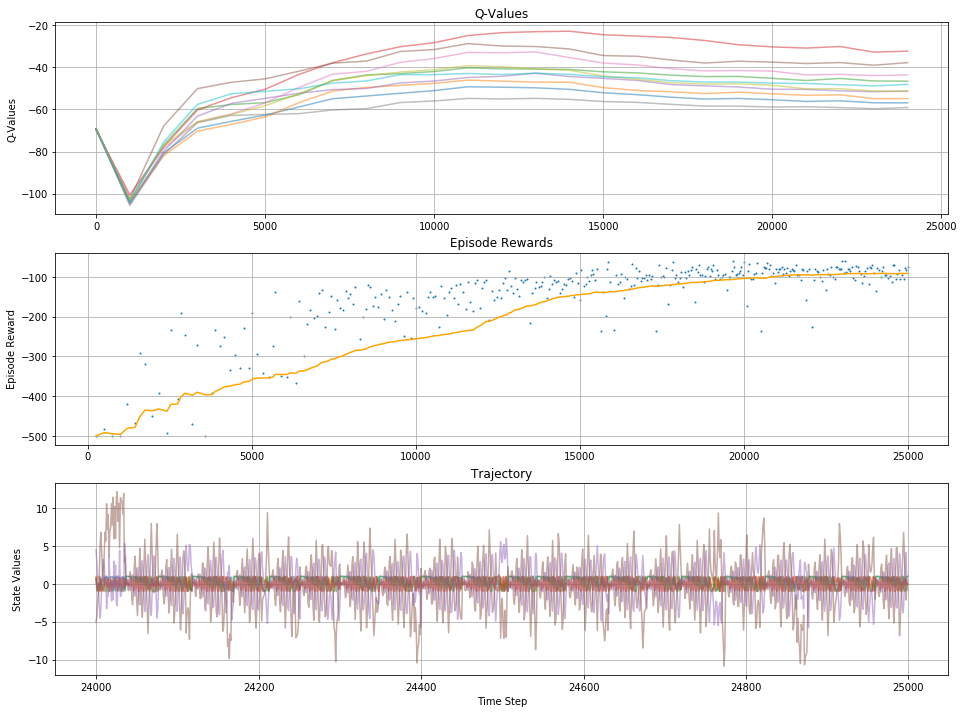

Where:
* Q_Max - is a plot of q-function max over possible actions
* Trajectory - is top-down view of agent trajectory. Agent starts roughly in the centre and exits to the right. Colour indicates action, see policy plot
* Q Values - is a plot of average q-values for set or randomly selected states - this shows how q-values develop during training
* Policy - is a top-down plot of agent policy. Green is accelerate right, red is accelerate left, blue is neutral
* Memory Buffer - is a snapshot of memory buffer, same format as Trajectory plot
* Episode Rewards - individual rewards acquired (blue dots) and running average (yellow) over the training period

# Lunar Lander

In [ ]:
def experiment_lunarlander():
    neural_net = TFNeuralNet(nb_in=8, nb_hid_1=64, nb_hid_2=64, nb_out=4, lr=0.00025)
    
    model = TFFunctApprox(neural_net,
                          st_low=np.array([-1., -1., -1., -1., -1., -1., -1., -1.]),
                          st_high=np.array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
                          rew_mean=0,
                          rew_std=1,
                          nb_actions=env.action_space.n)
    
    mem = Memory(max_len=100000, state_shape=(8,), state_dtype=float)
    mem_fill(env, mem, steps=10000)
    
    trace = Trace(eval_every=1000,
                  test_states=np.array([[0, 1.4, 0, 0, 0, 0, 0, 0],     # init
                                        [0, 0.7, 0, 0, 0, 0, 0, 0],     # half way
                                        [0, 0.0, 0, 0, 0, 0, 0, 0],]),  # landing pad
                  state_labels=['Pos.x', 'Pos.y', 'Vel.x', 'Vel.y',
                                'Angle', 'Ang. Vel', 'Left Leg', 'Right Leg'])
    
    return trace, model, mem

Setup the experiment

In [ ]:
env = gym.make('LunarLander-v2')
env = WrapFrameSkip(env, frameskip=2)  # 4?
trace, model, mem = experiment_lunarlander()

Train the agent

In [ ]:
tts = q_learning(env, frames=200000, gamma=.99,
                 eps_decay_steps=50000, eps_target=0.1, batch_size=4096,
                 model=model, mem=mem, callback=callback, trace=trace)

Optional: train some more

In [ ]:
# tts = q_learning(env, frames=5000, gamma=.99,
#                  eps_decay_steps=50000, eps_target=0.1, batch_size=4096,
#                  model=model, mem=mem, start_step=tts, callback=callback, trace=trace)

Optional: plot the agent state

In [ ]:
# helpers.plot_all(env, model, mem, trace, print_=True)

Save weights

In [ ]:
model._model.save('./tf_models/LunarLander.ckpt')

Load weights

In [ ]:
model._model.load('./tf_models/LunarLander.ckpt')

Enjoy trained agent

In [ ]:
try: evaluate(env, model, frames=float('inf'), eps=0.0, render=True)
except KeyboardInterrupt: pass
finally: env.close()

**Result**

Expected agent behaviour after 25000 iterations

<img src="assets/lunarlander.gif"/>

If you enable plotting, then output after training should be in roughly as follows

```

```

Where:
* Q_Max - is a plot of q-function max over possible actions
* Trajectory - is top-down view of agent trajectory. Agent starts roughly in the centre and exits to the right. Colour indicates action, see policy plot
* Q Values - is a plot of average q-values for set or randomly selected states - this shows how q-values develop during training
* Policy - is a top-down plot of agent policy. Green is accelerate right, red is accelerate left, blue is neutral
* Memory Buffer - is a snapshot of memory buffer, same format as Trajectory plot
* Episode Rewards - individual rewards acquired (blue dots) and running average (yellow) over the training period

# Render HTML5 Video

In [ ]:
import time

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:
def frames_render(env, frames, episodes, eps, model, callback=None, trace=None, render=True, sleep=0):

    rendered_frames = []
    
    def policy(st, model, eps):
        if np.random.rand() > eps:
            stack = np.stack([st])  # convert lazyframe to nn input shape [1, 84, 84, 4]
            q_values = model.eval(stack)
            return np.argmax(q_values)
        else:
            return env.action_space.sample()
        
    total_reward = 0
    
    tts_ = 0                                 # total time step
    for e_ in itertools.count():             # count from 0 to infinity
        
        S = env.reset()
        
        if render:
            rendered_frames.append(env.render(mode='rgb_array'))
            #env.render()
            time.sleep(sleep)
        
        for t_ in itertools.count():         # count from 0 to infinity
            
            # print(e_, t_)
            
            A = policy(S, model, eps)
            
            S_, R, done, info = env.step(A)
            
            #total_reward += info['full-reward']
            
            if render:
                rendered_frames.append(env.render(mode='rgb_array'))
                #env.render()
                time.sleep(sleep)
            
            if callback is not None:
                callback(tts_, e_, t_, S, A, R, done, eps, model, None, trace)
    
            if done:
                break
                
            if frames is not None and tts_ >= frames:
                return rendered_frames, total_reward
                
            S = S_
                
            tts_ += 1
            
        if episodes is not None and e_ >= episodes-1:
            return rendered_frames, total_reward

In [ ]:
env.close()

In [ ]:
evaluate(env, frames=None, episodes=1, eps=0.05, model=model, render=True)

In [ ]:
rendered_frames, total_reward = frames_render(env, frames=None, episodes=1, eps=0.05, model=model, render=True)

In [ ]:
plt.ioff()

fig = plt.figure(figsize=(rendered_frames[0].shape[1] / 72.0,
                          rendered_frames[0].shape[0] / 72.0), dpi = 72)
ax = fig.add_subplot(111);

patch = ax.imshow(rendered_frames[0])

plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False,
                right=False, labelbottom=False, labelleft=False)

In [ ]:
def animate(i):
    patch.set_data(rendered_frames[i])

In [ ]:
anim = animation.FuncAnimation(fig, animate, frames=len(rendered_frames), interval=20, repeat=True)


In [ ]:
HTML(anim.to_html5_video())

Then:
* r-click and download html5 video (will save as mp4)
* convert to gif with: https://ezgif.com/video-to-gif